29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training model with adversarial examples...


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3352 - loss: 2.0925 - val_accuracy: 0.6800 - val_loss: 0.9563
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6815 - loss: 0.9600 - val_accuracy: 0.7250 - val_loss: 0.7622
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7939 - loss: 0.6690 - val_accuracy: 0.7650 - val_loss: 0.6631
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.8527 - loss: 0.5053 - val_accuracy: 0.7700 - val_loss: 0.6621
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8886 - loss: 0.4030 - val_accuracy: 0.8000 - val_loss: 0.5760

Adversarially Trained Model Accuracy: 80.00%

Training model with Tangent Propagation...

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4012 - loss: 1.8111 - val_accuracy: 0.6350 - val_loss: 1.0179
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6819 - loss: 0.9385 - val_accuracy: 0.6800 - val_loss: 0.8192
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━

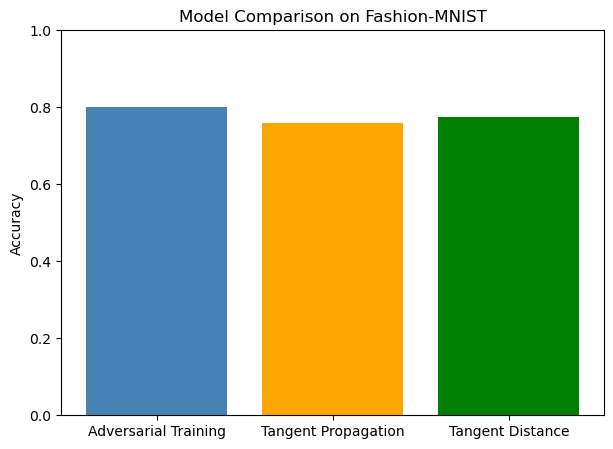

In [1]:
# ==============================================
#  Fashion-MNIST Adversarial & Tangent Training
# ==============================================

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Layer
import matplotlib.pyplot as plt

# -------------------------------
# Load and preprocess the dataset
# -------------------------------
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

subset_size = 1000
x_train = x_train[:subset_size] / 255.0
y_train = y_train[:subset_size]
x_test = x_test[:200] / 255.0
y_test = y_test[:200]

# -------------------------------
# Define a simple feed-forward model
# -------------------------------
def create_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# -------------------------------
# FGSM Adversarial Example Generator
# -------------------------------
def generate_adversarial_examples(model, x, y, epsilon=0.1):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.int64)
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        predictions = model(x_tensor, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_tensor, predictions)
    gradient = tape.gradient(loss, x_tensor)
    signed_grad = tf.sign(gradient)
    x_adv = x_tensor + epsilon * signed_grad
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv.numpy()

# -------------------------------
# Adversarial Training
# -------------------------------
print("Training model with adversarial examples...")

model_adv = create_model()

# Generate adversarial examples
x_adv = generate_adversarial_examples(model_adv, x_train, y_train, epsilon=0.1)

# Combine original + adversarial data
x_combined = np.concatenate([x_train, x_adv])
y_combined = np.concatenate([y_train, y_train])

# Train the model
history_adv = model_adv.fit(x_combined, y_combined, epochs=5,
                            validation_data=(x_test, y_test), verbose=1)

# Evaluate
loss_adv, accuracy_adv = model_adv.evaluate(x_test, y_test, verbose=0)
print(f'\nAdversarially Trained Model Accuracy: {accuracy_adv * 100:.2f}%')

# -------------------------------
# Tangent Propagation Layer
# -------------------------------
class TangentProp(Layer):
    def call(self, x):
        perturbation = tf.random.normal(shape=tf.shape(x), stddev=0.1)
        return x + perturbation

# -------------------------------
# Model with Tangent Propagation
# -------------------------------
print("\nTraining model with Tangent Propagation...")

model_tangent_prop = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(64, activation='relu'),
    TangentProp(),
    Dense(10, activation='softmax')
])

model_tangent_prop.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

history_tangent_prop = model_tangent_prop.fit(x_train, y_train, epochs=5,
                                              validation_data=(x_test, y_test), verbose=1)

loss_tangent_prop, accuracy_tangent_prop = model_tangent_prop.evaluate(x_test, y_test, verbose=0)
print(f'Tangent Prop Model Accuracy: {accuracy_tangent_prop * 100:.2f}%')

# -------------------------------
# Tangent Distance Classifier
# -------------------------------
def tangent_distance(x1, x2):
    """Euclidean tangent distance"""
    return np.linalg.norm(x1 - x2)

def classify_with_tangent_distance(x_train, y_train, x_test):
    """Classify each test image by nearest training image using tangent distance"""
    x_train_flat = x_train.reshape(x_train.shape[0], -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)
    preds = []

    for test_sample in x_test_flat:
        distances = np.linalg.norm(x_train_flat - test_sample, axis=1)
        nearest_idx = np.argmin(distances)
        preds.append(y_train[nearest_idx])

    return np.array(preds)

print("\nRunning Tangent Distance Classifier...")

y_pred_tangent = classify_with_tangent_distance(x_train, y_train, x_test)
accuracy_tangent_distance = np.mean(y_pred_tangent == y_test)
print(f'Tangent Distance Classifier Accuracy: {accuracy_tangent_distance * 100:.2f}%')

# -------------------------------
# Plot Accuracy Comparison
# -------------------------------
plt.figure(figsize=(7, 5))
models = ['Adversarial Training', 'Tangent Propagation', 'Tangent Distance']
accuracies = [accuracy_adv, accuracy_tangent_prop, accuracy_tangent_distance]
plt.bar(models, accuracies, color=['steelblue', 'orange', 'green'])
plt.ylabel('Accuracy')
plt.title('Model Comparison on Fashion-MNIST')
plt.ylim(0, 1)
plt.show()


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1985 - loss: 2.3983 - val_accuracy: 0.6100 - val_loss: 1.2369
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5975 - loss: 1.2503 - val_accuracy: 0.6850 - val_loss: 0.8859
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7011 - loss: 0.9180 - val_accuracy: 0.7200 - val_loss: 0.7801
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7683 - loss: 0.7472 - val_accuracy: 0.7350 - val_loss: 0.7264
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8128 - loss: 0.6267 - val_accuracy: 0.7350 - val_loss: 0.6889

Adversarially Trained Model Accuracy: 73.50%
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1991 - loss: 4.2895 - val_accuracy: 0.4400 - val_loss: 3.0519
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4742 - loss: 2.2947 - val_accuracy: 0.4850 - val_loss: 2.1598
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5459 - loss: 1.9

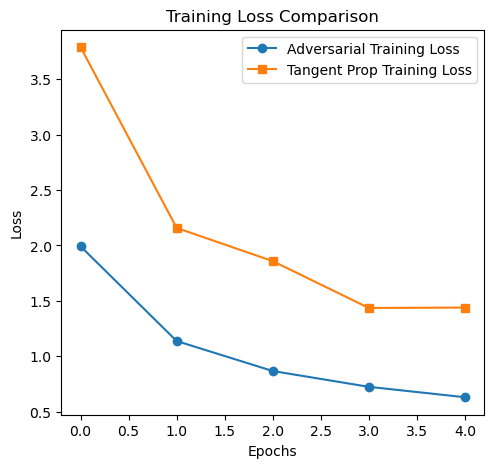

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Layer

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
subset_size = 1000
x_train = x_train[:subset_size].astype("float32") / 255.0
y_train = y_train[:subset_size]
x_test = x_test[:200].astype("float32") / 255.0
y_test = y_test[:200]

def create_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(64, activation="relu"),
        Dense(10, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def generate_adversarial_examples(model, x, y, epsilon=0.1):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.int64)
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        predictions = model(x_tensor, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_tensor, predictions)
    gradients = tape.gradient(loss, x_tensor)
    signed_grad = tf.sign(gradients)
    x_adv = x_tensor + epsilon * signed_grad
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv.numpy()

model_adv = create_model()
x_adv = generate_adversarial_examples(model_adv, x_train, y_train, epsilon=0.1)
x_combined = np.concatenate([x_train, x_adv], axis=0)
y_combined = np.concatenate([y_train, y_train], axis=0)

history_adv = model_adv.fit(x_combined, y_combined, epochs=5, batch_size=64, validation_data=(x_test, y_test), verbose=1)

loss_adv, accuracy_adv = model_adv.evaluate(x_test, y_test, verbose=0)
print(f"\nAdversarially Trained Model Accuracy: {accuracy_adv * 100:.2f}%")

# 2. TANGENT PROP
class TangentProp(Layer):
    def call(self, x):
        perturbation = tf.random.normal(shape=tf.shape(x), stddev=0.1)
        return x + perturbation


# Apply Tangent Prop to the model
model_tangent_prop = create_model()
model_tangent_prop.add(TangentProp())

history_tangent_prop = model_tangent_prop.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(x_test, y_test),
    verbose=1
)

loss_tangent_prop, accuracy_tangent_prop = model_tangent_prop.evaluate(x_test, y_test, verbose=0)
print(f"\nAdversarially Trained Model with Tangent Prop Accuracy: {accuracy_tangent_prop * 100:.2f}%")

# TANGENT DISTANCE
def tangent_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

# TANGENT CLASSIFIER
def classify_with_tangent_distance(x_train, y_train, x_test):
    x_train_flat = x_train.reshape(x_train.shape[0], -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)
    y_pred = []

    print(f"\nClassifying {len(x_test_flat)} test samples...")

    for i, test_sample in enumerate(x_test_flat):
        if (i + 1) % 20 == 0:
            print(f"Progress: {i + 1}/{len(x_test_flat)}")

        distances = [tangent_distance(test_sample, train_sample) for train_sample in x_train_flat]
        nearest_index = np.argmin(distances)
        y_pred.append(y_train[nearest_index])

    return np.array(y_pred)


y_pred_tangent = classify_with_tangent_distance(x_train, y_train, x_test)

accuracy_tangent = np.mean(y_pred_tangent == y_test)
print(f"\nTangent Distance Classifier Accuracy: {accuracy_tangent * 100:.2f}%")

# Plot training loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_adv.history['loss'], label='Adversarial Training Loss', marker='o')
plt.plot(history_tangent_prop.history['loss'], label='Tangent Prop Training Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()